<a href="https://colab.research.google.com/github/khodid/2020Evening/blob/master/2020Evening_proj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2020년 하계 프로젝트 \#1

- Evening 스터디 2020년 하계 방학 개인 프로젝트 \# 1
- 개발기간: 2020.07.31 ~ 8.3 ( 4 일 소요)
- 주제: VAE(Variational Auto-Encoder) 기능 구현 및 성능 확인

## 데이터 Import
- Dataset 출처 : [Scene Classification data](https://www.kaggle.com/nitishabharathi/scene-classification) (from Kaggle)


### About
- 선정 이유 : 음식 사진 다음으로 좋아하는 게 풍경사진임. 원래는 거리 사진 위주로 만들어볼까 했는데, 책에 있는 결과 이미지를 보니 아직까지 이 단계에선 이미지 합성이 조잡해 보였음. 좀 선명하게 구분되는 데이터로 트레이닝을 시켜보고자 이 데이터셋을 선택함.
- 내용: 빌딩 / 숲 / 산 / 빙하 / 거리 / 바다 5가지 카테고리 labeling된 **풍경 사진** 7301가지 (해상도는 150X150) 

In [ ]:
root = '/content/gdrive/My Drive/Kaggle/scene-classification/train-scene classification/train'

### How to

**이 쪽 코드는 거의 다 한 번만 돌려 주는 거라 주석 처리 해주겠음.**

참고자료: 
[Medium:: How to fetch kaggle datasets into google colab](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a)

1. Kaggle에서 내 계정의 API key를 다운 받는다.
2. Google Drive에 'Kaggle' 폴더를 생성해 API key를 넣는다.
3. Colab Notebook에 Google Drive를 mount시킨다.
4. kaggle.json 파일에 접근하기 위한 Config path를 설정해준다
5. 다운 받고 싶은 데이터가 있는 Kaggle 페이지로 가서, **\[ ... > Copy API command \]**를 선택해 다운로드 코드를 얻는다. 이 프로젝트의 경우엔
```python 
kaggle datasets download -d nitishabharathi/scene-classification
```
라는 코드로 복사 되었다.
Colab에서 이 코드 앞에 **!** 를 붙여서 실행한다.
6. 다운로드된 파일을 압축해제하고, 압축 파일을 제거한다.



In [ ]:
###  3. Google Drive 마운트 ###
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
###  4. Config path 제공  ###
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
###  현재 working directory 확인  ###
!pwd

/content


In [ ]:
###  working directory 변경  ###
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


(\* 디렉토리 확인 및 변경 부분은 그냥 따라한 거라서 잘 모르겠음. 디렉토리 관리 어디서 배우냐?)

In [ ]:
###  5. 데이터를 구글 드라이브로 다운로드  ###
###  한 번만 해주는 거라서 주석 처리하겠음 
# !kaggle datasets download -d nitishabharathi/scene-classification

In [ ]:
###  6. 압축해제  ###
# !unzip \*.zip  && rm *.zip

이 데이터셋의 경우,
/content/gdrive/My Drive/Kaggle/train-scene classification
에 이미지 파일이 담긴 train 폴더와 train.csv 파일이 담겨 있는 구성이었음.
train.csv 파일은 1열엔 각 이미지 파일의 이름, 2열엔 각 이미지 파일의 라벨이 붙은 자료.

## 데이터 가공하기

 다운 받는 건 성공했으니, 여기부턴 커스텀 데이터셋을 다루는 방법을 익혀서 적용해야 한다.

고려사항:

- classifiaction이 아니다 보니 training / test data를 나눠서 가져갈 필욘 없을 것 같다. 그냥 이미지와 label 매칭 시키는 정도만 하면 될 듯?
- 이미지 크기는 150 X 150으로 고정되어 있는 것 같아 size 조절은 크게 신경 쓰지 않아도 됨.
- ImageFolder 라이브러리를 쓰는 게 편할 것 같은데, 지금 레이블 별로 파일분류는 안 되어 있는 상태임. 따로 분류를 시킨 후에 쓰자.

참고자료:
- torch.utils.data.Dataset과 torch.utils.data.DataLoader를 이용해 커스텀 데이터셋 가공하기 https://wikidocs.net/57165
- Kaggle scene-classification data 튜토리얼(?) https://www.kaggle.com/manhnguyenthe/jackmon
- Kaggle PyTorch dataloader 튜토리얼 https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader

### 이미지를 라벨 별로 나눠서 저장하기

csv 파일로 기록된 것을 기반으로 서로 다른 폴더에 넣어주는 작업이 필요할 듯함.
이 것과 관련해선 데이터 다운 받았던 곳에 예제가 있던데, pandas 패키지를 사용하느냐 csv 패키지를 사용하느냐 선택할 수 있음.
일단 pandas를 사용해보겠다.

In [ ]:
import pandas as pd

### 튜토리얼에서 코드 퍼옴
### 데이터를 pandas의 dataframe형에 넣고 출력

nRowsRead = None # 데이터를 몇 줄이나 읽어올 것인지 설정. 만약 끝까지 다 읽을 거라면 None으로.
df1 = pd.read_csv('/content/gdrive/My Drive/Kaggle/scene-classification/train-scene classification/train.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'train.csv'
df2 = pd.read_csv('/content/gdrive/My Drive/Kaggle/scene-classification/test_WyRytb0.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'test_WyRytb0.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')
print(df2.shape)

There are 17034 rows and 2 columns
(7301, 1)


In [ ]:
df1.head(7)

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4
5,8.jpg,1
6,9.jpg,5


In [ ]:
print(df1.values[0][0])
print('0' in df1.values[0][0])
print(df1.label[2])

0.jpg
True
5


고민도 많이 해보고, Data Loading 관련해서 검색도 많이 했는데, 당장은 그냥 모든 이미지에 대해서 label을 찾아주고 거기에 맞는 디렉토리에 분류한 후 torch.ulits.data.ImageFolder를 사용하는 것이 걸맞은 것 같음.

디렉토리 정리 레퍼런스
- https://wikidocs.net/3717
- https://bigdatapy.tistory.com/198
- https://m.blog.naver.com/dydgus092/221287570550


In [ ]:
###  연습장  ###
root = '/content/gdrive/My Drive/Kaggle/scene-classification/train-scene classification/train'
path = root + '/' + str(df1.label[2])
# print(path)
print(root + '/' + df1.image_name[2])
print(path + '/' + df1.image_name[2])

/content/gdrive/My Drive/Kaggle/scene-classification/train-scene classification/train/2.jpg
/content/gdrive/My Drive/Kaggle/scene-classification/train-scene classification/train/5/2.jpg


In [ ]:
###  파일을 라벨별 폴더로 옮기는 작업. 1회성이라 주석 처리함  ### 
# 이쪽은 100퍼 직접 짠 거라서 개선 필요할 수도 있음
# import os
# root = '/content/gdrive/My Drive/Kaggle/scene-classification/train-scene classification/train'

# for iter,name in enumerate(df1.image_name):
#   path = root + '/' + str(df1.label[iter])
#   if not os.path.exists(path): 
#     os.mkdir(path)
#   else:
#     os.rename(root + '/' + name, path + '/' + name)

In [ ]:
### 1회성 코드 ### 

## 라벨 없는 나머지는 걍 지움
# for item in os.listdir(root):
#   if ('.jpg' in item):
#     os.remove( root + '/'+ item)

### Train_data 완성
ImageFolder로 불러오기 성공...

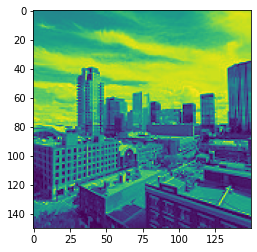

In [ ]:
import torchvision
from torchvision import transforms

trans= transforms.Compose([
                              transforms.Resize([150, 150]),
                              transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(root = root, transform= trans)

from matplotlib.pyplot import imshow

imshow(train_data[0][0][1,:,:]) # train_data[순서][0: 이미지 / 1: 라벨]

In [ ]:
# 데이터 로더 설정. batch size는 100으로!
batch_size = 20
import torch
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last=True)

## VAE 설계하기

일단 처음이니깐.. 교재에서 짠 구성을 많이 참고해야 할 듯.

- 교재 예제 specifications
 ```python
vae = VariationalAutoencoder(
                input_dim = (128,128,3)
                , encoder_conv_filters=[32,64,64, 64]
                , encoder_conv_kernel_size=[3,3,3,3]
                , encoder_conv_strides=[2,2,2,2]
                , decoder_conv_t_filters=[64,64,32,3]
                , decoder_conv_t_kernel_size=[3,3,3,3]
                , decoder_conv_t_strides=[2,2,2,2]
                , z_dim=200
                , use_batch_norm=True
                , use_dropout=True)
```

In [ ]:
 import torch
# GPU 환경 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [ ]:
# input size 알아내기
train_data[0][0].shape

torch.Size([3, 150, 150])

### VAE model 정의
교재 Github에서 VAE.py 파일 구현한 것과 모델 선언 파라미러를 참고하면서
교재에서 케라스로 하던 걸 pytorch.nn 패키지로 바꾸면서 구현.
- 참고한 페이지
 - torch.nn 설명문서 
   - [nn.Conv2d()](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html)
   - [nn.LeakyReLU()](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
   - [nn.Dropout()](https://pytorch.org/docs/master/generated/torch.nn.Dropout.html): VAE.py를 보니 비율을 0.25로 설정해놨음
   - [nn.Flatten()](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)
   - [nn.ConvTranspose2d()](https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose2d.html): output size에 유념해야 함. 대충 (input-1)*stride+kernel_size 해주면 된다.
 - [Pytorch에서 제공하는 VAE example](https://github.com/pytorch/examples/blob/master/vae/main.py#L58). 실제 구현 쪽에서 참고했음
 - [CNN-VAE 프로젝트 코드](https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb): model 구조와 텐서 흐름 카피 많이 함.
 - [Keras의 함수와 대응되는 PyTorch의 함수들.](https://discuss.pytorch.org/t/pytorch-equivalent-of-keras/29412/2)


 잠재공간의 차원은 교재의 CelebA예제에선 200개로 했던데, 연산량 넘 많을 것 같아서 대충 20 정도로 해보겠음.


In [ ]:
import torch.nn as nn

input_shape = train_data[0][0].shape

class VAE(torch.nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    self.encoder = nn.Sequential(
        # input size = (150, 150), channel = 3
        nn.Conv2d(3, 32, kernel_size=3, stride=2), # (3, 150, 150) -> (32, 74, 74)
        nn.BatchNorm2d(32),  
        nn.LeakyReLU(),  
        nn.Dropout(p=0.25),
        
        nn.Conv2d(32, 64, kernel_size=3, stride = 2), # (32, 74, 74) -> (64, 36, 36)  
        nn.BatchNorm2d(64),  
        nn.LeakyReLU(),    
        nn.Dropout(p=0.25),

        nn.Conv2d(64, 20, kernel_size=3, stride=2),   # (64, 36, 36) -> (20, 17, 17)
        nn.BatchNorm2d(20),   
        nn.LeakyReLU(), 
        nn.Dropout(p=0.25),

        nn.Flatten()
        # output size = 17*17*20 = 5780 = h_dim
        )
    
    self.fc_mu = nn.Linear(5780, 20)
    self.fc_log_var = nn.Linear(5780, 20)
    self.fc_decode = nn.Linear(20, 5780)

    self.decoder = nn.Sequential(
        # nn.Unflatten(1, (20,17,17)), # pytorch 문서로는 존재하는데 nn에 Unflatten이 없다는 오류가 뜸

        nn.ConvTranspose2d(20, 64 ,kernel_size=4, stride=2), # (20, 17, 17) -> (64, 36, 36)
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.Dropout(p=0.25),

        nn.ConvTranspose2d(64, 32 ,kernel_size=4, stride=2),# (64, 36, 36) -> (32, 74, 74)
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),
        nn.Dropout(p=0.25),
        
        nn.ConvTranspose2d(32, 3 ,kernel_size=4, stride=2),# (32, 74, 74) -> (3, 150, 150)
        nn.Sigmoid(),
    )
    
  def encode(self, x):
    h = self.encoder(x)
    # print(h.shape)  # (batch_size, 5780)
    mu, log_var = self.fc_mu(h), self.fc_log_var(h)
    z = self.reparameterize(mu, log_var)
    return z, mu, log_var

  def reparameterize(self, mu, log_var):
    sigma = torch.exp(0.5*log_var)  # 교재 p108 참고
    epsilon = torch.randn_like(sigma) # sigma와 같은 크기의 정규분포 랜덤 텐서 생성
    return mu + sigma * epsilon

  def decode(self, z):
    z = self.fc_decode(z)
    z = self.decoder(z.view(z.size(0), 20, 17, 17))
    return z

  def forward(self, x):
    z, mu, log_var = self.encode(x)
    z = self.decode(z)
    return z, mu, log_var

In [ ]:
# model 내 input-output size 맞춘 것 확인

tst_model = VAE().to(device)
tst_input = (torch.rand(1, 3, 150, 150)).to(device)
tst_out = tst_model(tst_input)

# print(len(tst_out)) # (z, mu, log_var) 3가지 텐서를 담고 있는 tuple 형
tst_gen_img, tst_mu, tst_log_var = tst_out
# print(tst_gen_img.shape)
# print(tst_mu.shape)
# print(tst_log_var.shape)

tst_z, _, _ = tst_model.encode(tst_input)
print(tst_z.shape)

torch.Size([1, 20])


### Loss Function 정의

교재에서 소개한 건
- reconstruction loss ... p98
  - Root Mean Squared Error Loss(RMSE Loss)
  - Binary Cross Entropy Loss(BCE Loss): BCE는 어긋난 예측에 대한 패널티가 커서 픽셀 예측값을 너무 중간값으로 만들어버리는 경향이 있다고 함. 그래도 둘 중 뭘 선택하느냐는 case by case!
- Kullback-Leibker divergence(KL발산) ... p112

이 두 가지가 있고, reconstruction loss는 AE에도 있지만 KL 발산의 경우엔 분포와 관련된 것이기 때문에 AE에선 없고 VAE에만 있다.

최종 Loss는 이 두가지를 더한다.

In [ ]:
def loss_function(x, target, mu, log_var):
  x, target = x.view(-1), target.view(-1) # 안 넣으면 오류남
  rmse_loss = torch.sqrt(torch.mean(torch.square(target - x)) + 1e-7) # p98 참고 # 0 되는 걸 방지하기 위해
  kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) # p112 참고

  return rmse_loss, kl_div, rmse_loss + kl_div

In [ ]:
# loss function 크기 테스트
r, k, l = loss_function(tst_gen_img, tst_input, tst_mu, tst_log_var )
print(r)
print(k)
print(l)

tensor(0.3294, device='cuda:0', grad_fn=<SqrtBackward>)
tensor(4.5057, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.8352, device='cuda:0', grad_fn=<AddBackward0>)


## 모델 저장 & 로드 함수 짜기

이쪽은 그냥 [PyTorch 튜토리얼](https://tutorials.pytorch.kr/beginner/saving_loading_models.html) 보고 따라했음.

In [ ]:
# 중간세이브 코드
import os
def save_model(model, save_dir, file_name = 'scene_vae_param.pt'):
  save_path = save_dir + '/' + file_name
  check_point = {'model_state_dict':model.state_dict(),
                 'epoch': epoch,
                 'optimizer_state_dict': optimizer.state_dict(),
                 'loss': loss
                 }
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  torch.save(check_point, save_path)

In [ ]:
save_model(model, '/content/gdrive/My Drive/Kaggle/scene-classification')

In [ ]:
# model = TheModelClass(*args, **kwargs)
# optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load('/content/gdrive/My Drive/Kaggle/scene-classification/scene_vae_param.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# model.eval()
# # - or -
model.train()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 20, kernel_size=(3, 3), stride=(2, 2))
    (9): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.25, inplace=False)
    (12): Flatten()
  )
  (fc_mu): Linear(in_features=5780, out_features=20, bias=True)
  (fc_log_var): Linear(in_features=5780, out_features=20, bias=True)
  (fc_decode): Linear(in_features=20, out_features=5780, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(20, 64, ke

## Training


In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    for idx, (img, label) in enumerate(train_loader):
        img = img.to(device)
        gen_img, mu, log_var = model(img)
        r, k, loss = loss_function(gen_img, img, mu, log_var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (idx+1)%10 == 0 : print("Epoch[{}/{}][Step{}/{}] Loss: {:.3f}".format(epoch+1, num_epochs, idx+1, len(train_loader), loss.item()))
    save_model(model, '/content/gdrive/My Drive/Kaggle/scene-classification') # 한 에폭 진행할 때마다 중간저장
print("★☆ Training 완료!!! ☆★")

Epoch[1/5][Step10/170] Loss: 0.546
Epoch[1/5][Step20/170] Loss: 0.416
Epoch[1/5][Step30/170] Loss: 0.375
Epoch[1/5][Step40/170] Loss: 0.318
Epoch[1/5][Step50/170] Loss: 0.322
Epoch[1/5][Step60/170] Loss: 0.313
Epoch[1/5][Step70/170] Loss: 0.299
Epoch[1/5][Step80/170] Loss: 0.311
Epoch[1/5][Step90/170] Loss: 0.305
Epoch[1/5][Step100/170] Loss: 0.282
Epoch[1/5][Step110/170] Loss: 0.289
Epoch[1/5][Step120/170] Loss: 0.289
Epoch[1/5][Step130/170] Loss: 0.295
Epoch[1/5][Step140/170] Loss: 0.284
Epoch[1/5][Step150/170] Loss: 0.273
Epoch[1/5][Step160/170] Loss: 0.281
Epoch[1/5][Step170/170] Loss: 0.281
Epoch[2/5][Step10/170] Loss: 0.287
Epoch[2/5][Step20/170] Loss: 0.279
Epoch[2/5][Step30/170] Loss: 0.270
Epoch[2/5][Step40/170] Loss: 0.277
Epoch[2/5][Step50/170] Loss: 0.279
Epoch[2/5][Step60/170] Loss: 0.281
Epoch[2/5][Step70/170] Loss: 0.273
Epoch[2/5][Step80/170] Loss: 0.269
Epoch[2/5][Step90/170] Loss: 0.273
Epoch[2/5][Step100/170] Loss: 0.275
Epoch[2/5][Step110/170] Loss: 0.274
Epoch[2/5]

## 이미지 생성

1. 랜덤한 이미지 생성(p120)
2. 라벨에 맞는 이미지 생성(p121~122)
3. 두 이미지 합성하기

... 를 시도해볼 생각임. 
plot 관련한 건 교재 깃헙과 모딥 공부할 때 썼던 코드 섞어 썼음.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

### 재생성 성능 확인
위 기능을 해보기 앞서 재생성이 잘 되는지 지켜봐야겠음.

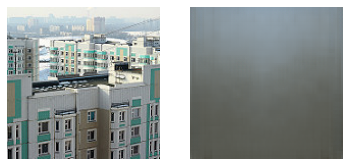

In [ ]:
data_idx = 15
# 이미지 생성

model = model.eval()

original_img, label = train_data[data_idx]
original_img = original_img.reshape(1,3,150,150).to(device)
gen_img, _, _ = model(original_img)

# 이미지 출력 by matplotlib, numpy
fig = plt.figure()

original_img = original_img[0].cpu().numpy()
sub = fig.add_subplot(1, 2, 1)
sub.axis('off')
sub.imshow(np.transpose(original_img, (1, 2, 0))) # tensor에서 ndarray로 바꿔줘야 imshow에 넣을 수 있는 듯?

gen_img = gen_img[0].cpu().detach().numpy()
sub = fig.add_subplot(1, 2, 2)
sub.axis('off')
sub.imshow(np.transpose(gen_img, (1, 2, 0))) # grad가 포함된 어쩌구는 안 된대서 detach().numpy까지 시도함.

In [ ]:
original_img, label = train_data[data_idx]
original_img = original_img.reshape(1,3,150,150).to(device)
gen_img, _, _ = model(original_img)
rmse_loss = torch.sqrt(torch.mean(torch.square(original_img - gen_img)) + 1e-7)
print(rmse_loss)

tensor(0.2309, device='cuda:0', grad_fn=<SqrtBackward>)


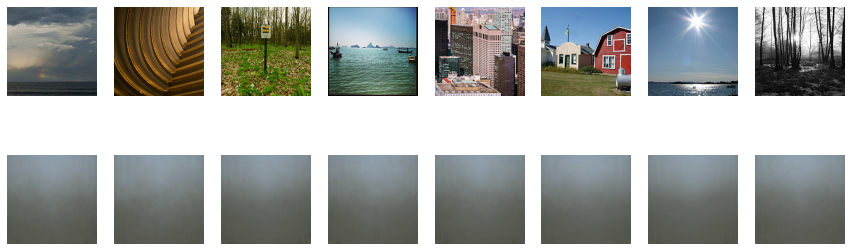

In [ ]:
column, row = 8, 2
fig = plt.figure(figsize = (15,5))

for i in range(1, column + 1):
  data_idx = np.random.randint(len(train_data))
  original_img, label = train_data[data_idx]
  original_img = original_img.reshape(1,3,150,150).to(device)
  gen_img, _, _ = model(original_img)
  
  gen_img, original_img = gen_img.cpu(), original_img.cpu()
  
  sub = fig.add_subplot(row, column, i)
  sub.axis('off')        
  sub.imshow(np.transpose(original_img[0].numpy(), (1, 2, 0)))
  sub = fig.add_subplot(row, column, i + column)
  sub.axis('off')
  sub.imshow(np.transpose(gen_img[0].detach().numpy(), (1, 2, 0)))

### 랜덤 이미지 생성
잠재 공간 상의 벡터를 아예 random한 수로 입력해서 이미지 생성하기.

In [ ]:
imshow(train_data[0][0][1,:,:]) # train_data[순서][0: 이미지 / 1: 라벨]

In [ ]:
num_to_show = 20
z_rand_point = np.random.normal(size = (num_to_show,20))
reconst = model.decoder(z_rand_point)

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(num_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(np.transpose(reconst[i].detach().numpy(), (1, 2, 0)))
    ax.axis('off')
    plt.show()

TypeError: ignored